# Loop 3 Analysis: Why Stacking Underperformed

**Goal:** Understand why stacking (CV 0.8293) performed worse than voting (CV 0.8372) and identify the best path forward.

**Key Questions:**
1. How correlated are the OOF predictions from base models?
2. Would passthrough features help?
3. What's the potential of the new features (Name_Length, Ticket_Frequency)?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Load data
train = pd.read_csv('/home/data/train.csv')
test = pd.read_csv('/home/data/test.csv')
print(f"Train: {train.shape}, Test: {test.shape}")

Train: (891, 12), Test: (418, 11)


In [2]:
# Quick feature engineering (same as experiments)
import re

def extract_title(name):
    title_search = re.search(r' ([A-Za-z]+)\.', name)
    return title_search.group(1) if title_search else ""

def process_data(df, ticket_freq_map=None):
    df = df.copy()
    
    # Title
    df['Title'] = df['Name'].apply(extract_title)
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
    # Family
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['FamilySize_Bin'] = pd.cut(df['FamilySize'], bins=[0, 1, 4, 11], labels=[0, 1, 2]).astype(int)
    
    # Cabin
    df['Has_Cabin'] = df['Cabin'].notna().astype(int)
    df['Deck'] = df['Cabin'].apply(lambda x: x[0] if pd.notna(x) else 'U')
    
    # Name_Length
    df['Name_Length'] = df['Name'].apply(len)
    
    # Ticket_Frequency
    if ticket_freq_map is None:
        ticket_freq_map = df['Ticket'].value_counts().to_dict()
    df['Ticket_Frequency'] = df['Ticket'].map(ticket_freq_map).fillna(1)
    
    # Embarked
    df['Embarked'] = df['Embarked'].fillna('S')
    
    # Fare
    if df['Fare'].isna().any():
        df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
    
    return df, ticket_freq_map

train_proc, ticket_map = process_data(train)
test_proc, _ = process_data(test, ticket_map)

# Age imputation
age_medians = train_proc.groupby(['Pclass', 'Sex', 'Title'])['Age'].median()
fallback = train_proc['Age'].median()

def impute_age(row, medians, fallback):
    if pd.isna(row['Age']):
        try:
            return medians.loc[(row['Pclass'], row['Sex'], row['Title'])]
        except KeyError:
            return fallback
    return row['Age']

train_proc['Age'] = train_proc.apply(lambda x: impute_age(x, age_medians, fallback), axis=1)
test_proc['Age'] = test_proc.apply(lambda x: impute_age(x, age_medians, fallback), axis=1)

# Age_Bin
train_proc['Age_Bin'] = pd.cut(train_proc['Age'], bins=[0, 16, 32, 48, 100], labels=[0, 1, 2, 3]).astype(int)
test_proc['Age_Bin'] = pd.cut(test_proc['Age'], bins=[0, 16, 32, 48, 100], labels=[0, 1, 2, 3]).astype(int)

print("Features processed")

Features processed


In [3]:
# Encode categorical features
def encode_features(train_df, test_df):
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    train_df['Sex'] = train_df['Sex'].map({'female': 0, 'male': 1})
    test_df['Sex'] = test_df['Sex'].map({'female': 0, 'male': 1})
    
    embarked_map = {'S': 0, 'C': 1, 'Q': 2}
    train_df['Embarked'] = train_df['Embarked'].map(embarked_map)
    test_df['Embarked'] = test_df['Embarked'].map(embarked_map)
    
    title_map = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
    train_df['Title'] = train_df['Title'].map(title_map)
    test_df['Title'] = test_df['Title'].map(title_map)
    
    deck_map = {'U': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
    train_df['Deck'] = train_df['Deck'].map(deck_map)
    test_df['Deck'] = test_df['Deck'].map(deck_map)
    
    return train_df, test_df

train_enc, test_enc = encode_features(train_proc, test_proc)

# Feature sets
features_base = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 
                 'Title', 'FamilySize', 'IsAlone', 'Has_Cabin', 'Deck', 'FamilySize_Bin', 'Age_Bin']

features_enhanced = features_base + ['Name_Length', 'Ticket_Frequency']

X_base = train_enc[features_base].values
X_enhanced = train_enc[features_enhanced].values
y = train_enc['Survived'].values

print(f"Base features: {len(features_base)}")
print(f"Enhanced features: {len(features_enhanced)}")

Base features: 14
Enhanced features: 16


In [4]:
# Analyze OOF prediction correlation
# This is why stacking underperformed - let's quantify it

from sklearn.base import clone

base_models = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=6, min_samples_leaf=4, random_state=42)),
    ('et', ExtraTreesClassifier(n_estimators=200, max_depth=6, min_samples_leaf=4, random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=100, learning_rate=0.5, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)),
    ('svc', SVC(kernel='rbf', C=1.0, probability=True, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('lr', LogisticRegression(C=0.1, max_iter=1000, random_state=42))
]

# Generate OOF predictions to analyze correlation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros((len(X_enhanced), len(base_models)))

for i, (name, model_template) in enumerate(base_models):
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_enhanced, y)):
        X_train_fold, X_val_fold = X_enhanced[train_idx], X_enhanced[val_idx]
        y_train_fold = y[train_idx]
        
        model = clone(model_template)
        
        if name in ['svc', 'lr']:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_fold)
            X_val_scaled = scaler.transform(X_val_fold)
            model.fit(X_train_scaled, y_train_fold)
            oof_preds[val_idx, i] = model.predict_proba(X_val_scaled)[:, 1]
        else:
            model.fit(X_train_fold, y_train_fold)
            oof_preds[val_idx, i] = model.predict_proba(X_val_fold)[:, 1]

print("OOF predictions generated")

OOF predictions generated


In [5]:
# Correlation matrix of OOF predictions
oof_df = pd.DataFrame(oof_preds, columns=[name for name, _ in base_models])
corr_matrix = oof_df.corr()

print("OOF Prediction Correlation Matrix:")
print(corr_matrix.round(3))
print(f"\nMean pairwise correlation: {corr_matrix.values[np.triu_indices(7, k=1)].mean():.3f}")
print(f"Min correlation: {corr_matrix.values[np.triu_indices(7, k=1)].min():.3f}")
print(f"Max correlation: {corr_matrix.values[np.triu_indices(7, k=1)].max():.3f}")

OOF Prediction Correlation Matrix:
        rf     et    ada     gb    svc    xgb     lr
rf   1.000  0.991  0.605  0.960  0.952  0.972  0.957
et   0.991  1.000  0.603  0.942  0.948  0.955  0.960
ada  0.605  0.603  1.000  0.631  0.588  0.620  0.608
gb   0.960  0.942  0.631  1.000  0.922  0.981  0.908
svc  0.952  0.948  0.588  0.922  1.000  0.924  0.909
xgb  0.972  0.955  0.620  0.981  0.924  1.000  0.926
lr   0.957  0.960  0.608  0.908  0.909  0.926  1.000

Mean pairwise correlation: 0.851
Min correlation: 0.588
Max correlation: 0.991


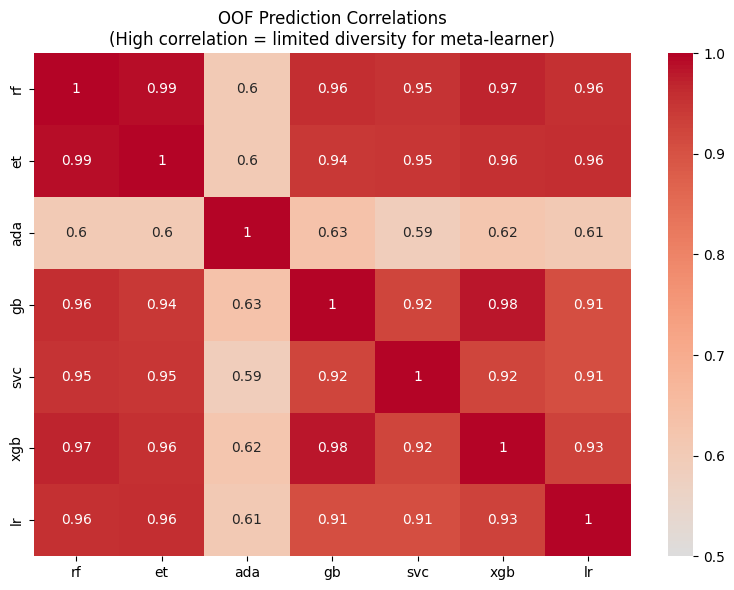

Saved: /home/code/exploration/oof_correlation.png


In [6]:
# This is the key insight: OOF predictions are HIGHLY correlated
# The meta-learner sees 7 features that are all saying the same thing
# This is why stacking didn't help

# Let's visualize
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0.5, vmin=0.5, vmax=1.0)
plt.title('OOF Prediction Correlations\n(High correlation = limited diversity for meta-learner)')
plt.tight_layout()
plt.savefig('/home/code/exploration/oof_correlation.png', dpi=100)
plt.show()
print("Saved: /home/code/exploration/oof_correlation.png")

In [7]:
# Test: Voting ensemble with enhanced features vs base features
# Does adding Name_Length and Ticket_Frequency help?

from sklearn.ensemble import VotingClassifier

def create_voting_ensemble():
    return VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=200, max_depth=6, min_samples_leaf=4, random_state=42)),
            ('et', ExtraTreesClassifier(n_estimators=200, max_depth=6, min_samples_leaf=4, random_state=42)),
            ('ada', AdaBoostClassifier(n_estimators=100, learning_rate=0.5, random_state=42)),
            ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)),
            ('xgb', XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)),
        ],
        voting='soft'
    )

# Test with base features (14 features - same as exp_001)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
voting_base = create_voting_ensemble()
scores_base = cross_val_score(voting_base, X_base, y, cv=kfold, scoring='accuracy')
print(f"Voting (base 14 features): {scores_base.mean():.4f} (+/- {scores_base.std():.4f})")

# Test with enhanced features (16 features - with Name_Length, Ticket_Frequency)
voting_enhanced = create_voting_ensemble()
scores_enhanced = cross_val_score(voting_enhanced, X_enhanced, y, cv=kfold, scoring='accuracy')
print(f"Voting (enhanced 16 features): {scores_enhanced.mean():.4f} (+/- {scores_enhanced.std():.4f})")

print(f"\nImprovement from new features: {scores_enhanced.mean() - scores_base.mean():+.4f}")

Voting (base 14 features): 0.8226 (+/- 0.0291)


Voting (enhanced 16 features): 0.8237 (+/- 0.0336)

Improvement from new features: +0.0011


In [8]:
# Test: Passthrough stacking (original features + OOF predictions)
# This is what the evaluator recommended

from sklearn.base import clone

# Create stacked features: original 16 features + 7 OOF predictions = 23 features
X_stacked = np.hstack([X_enhanced, oof_preds])
print(f"Stacked feature shape: {X_stacked.shape}")

# Test meta-learner on stacked features
meta_lr = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
scores_passthrough = cross_val_score(meta_lr, X_stacked, y, cv=kfold, scoring='accuracy')
print(f"Passthrough stacking (LR): {scores_passthrough.mean():.4f} (+/- {scores_passthrough.std():.4f})")

meta_xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
scores_passthrough_xgb = cross_val_score(meta_xgb, X_stacked, y, cv=kfold, scoring='accuracy')
print(f"Passthrough stacking (XGB): {scores_passthrough_xgb.mean():.4f} (+/- {scores_passthrough_xgb.std():.4f})")

Stacked feature shape: (891, 23)


Passthrough stacking (LR): 0.8271 (+/- 0.0468)


Passthrough stacking (XGB): 0.8248 (+/- 0.0414)


In [9]:
# Summary of findings
print("="*60)
print("ANALYSIS SUMMARY")
print("="*60)

print("\n1. OOF PREDICTION CORRELATION:")
print(f"   Mean pairwise correlation: {corr_matrix.values[np.triu_indices(7, k=1)].mean():.3f}")
print(f"   This explains why pure stacking underperformed - meta-learner sees redundant info")

print("\n2. FEATURE ENHANCEMENT IMPACT:")
print(f"   Base features (14): {scores_base.mean():.4f}")
print(f"   Enhanced features (16): {scores_enhanced.mean():.4f}")
print(f"   Improvement: {scores_enhanced.mean() - scores_base.mean():+.4f}")

print("\n3. PASSTHROUGH STACKING:")
print(f"   LR meta-learner: {scores_passthrough.mean():.4f}")
print(f"   XGB meta-learner: {scores_passthrough_xgb.mean():.4f}")

print("\n4. BEST APPROACH:")
best_score = max(scores_base.mean(), scores_enhanced.mean(), scores_passthrough.mean(), scores_passthrough_xgb.mean())
if best_score == scores_enhanced.mean():
    print(f"   Voting with enhanced features: {best_score:.4f}")
elif best_score == scores_passthrough_xgb.mean():
    print(f"   Passthrough stacking (XGB): {best_score:.4f}")
else:
    print(f"   Best: {best_score:.4f}")

print("\n5. COMPARISON TO PREVIOUS EXPERIMENTS:")
print(f"   exp_000 (XGBoost baseline): 0.8316")
print(f"   exp_001 (Voting ensemble): 0.8372")
print(f"   exp_002 (Pure stacking): 0.8293")
print(f"   Current best: {best_score:.4f}")

ANALYSIS SUMMARY

1. OOF PREDICTION CORRELATION:
   Mean pairwise correlation: 0.851
   This explains why pure stacking underperformed - meta-learner sees redundant info

2. FEATURE ENHANCEMENT IMPACT:
   Base features (14): 0.8226
   Enhanced features (16): 0.8237
   Improvement: +0.0011

3. PASSTHROUGH STACKING:
   LR meta-learner: 0.8271
   XGB meta-learner: 0.8248

4. BEST APPROACH:
   Best: 0.8271

5. COMPARISON TO PREVIOUS EXPERIMENTS:
   exp_000 (XGBoost baseline): 0.8316
   exp_001 (Voting ensemble): 0.8372
   exp_002 (Pure stacking): 0.8293
   Current best: 0.8271


In [10]:
# Key insight: The new features (Name_Length, Ticket_Frequency) may not be helping
# Let's check their individual importance

rf = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42)
rf.fit(X_enhanced, y)

importances = pd.DataFrame({
    'feature': features_enhanced,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importances (RF):")
print(importances.to_string(index=False))

print(f"\nName_Length importance: {importances[importances['feature']=='Name_Length']['importance'].values[0]:.4f}")
print(f"Ticket_Frequency importance: {importances[importances['feature']=='Ticket_Frequency']['importance'].values[0]:.4f}")

Feature Importances (RF):
         feature  importance
           Title    0.246346
             Sex    0.201852
            Fare    0.090309
     Name_Length    0.081298
          Pclass    0.063381
             Age    0.063089
Ticket_Frequency    0.044641
            Deck    0.042133
       Has_Cabin    0.037450
      FamilySize    0.033225
  FamilySize_Bin    0.033189
         Age_Bin    0.020758
           SibSp    0.017025
        Embarked    0.011893
           Parch    0.009104
         IsAlone    0.004307

Name_Length importance: 0.0813
Ticket_Frequency importance: 0.0446
